In [4]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re

import numpy as np
import pandas as pd

from importlib import reload

In [6]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import tensorflow as tf
tf.__version__

'1.13.0-rc2'

In [2]:
main_dir = '/home/yulia/W266-Final-Project/'

In [13]:
data_path = main_dir+'data/raw/hein-daily'

## Load processed files

In [19]:
outdata_path = main_dir+'Classification/data/splits/gender'

In [20]:
with open(os.path.join(outdata_path, 'train_list'), 'rb') as fp:
    train = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_ids'), 'rb') as fp:
    train_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_target'), 'rb') as fp:
    train_target = pickle.load(fp)

In [21]:
with open(os.path.join(outdata_path, 'val_list'), 'rb') as fp:
    val = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)

In [3]:
token_path = main_dir+'Classification/data/tokenized/gender'

In [7]:
train_vec = np.load(os.path.join(token_path, 'train_vec.npy'))
val_vec = np.load(os.path.join(token_path, 'val_vec.npy'))
test_vec = np.load(os.path.join(token_path, 'test_vec.npy'))

In [26]:
word_index = pickle.load(open(os.path.join(token_path, 'word_index.p'), 'rb'))

In [8]:
len(train_vec), len(val_vec), len(test_vec)

(188148, 62716, 62716)

## CNN model - Full Speech + Glove Embeddings

In [24]:
logs_base_dir = main_dir + 'Classification/logs/gender'

In [40]:
sepcnn_model_params = {
    'model': 'sepcnn',
    'word_index': word_index,
    'learning_rate': 0.001,
    'layers': 2,
    'epochs': 1000,
    'batch_size': 128,
    'blocks': 2,
    'filters': 64,
    'dropout_rate': 0.2,
    'embedding_dim': 200,
    'kernel_size': 5,
    'pool_size': 3,
    'max_num_words': 20000,
    'use_pretrained_embedding': True,
    'is_embedding_trainable': True,
    'glove_dir': main_dir + 'data'
}

In [42]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), logs_base_dir, **sepcnn_model_params)

Found 400000 word vectors.
It took 23.4 seconds
Preparing embedding matrix.
Embedding matrix has been built.
Its shape is (20000, 200).
It took 0.1 seconds
Train on 188148 samples, validate on 62716 samples
Epoch 1/1000
 - 842s - loss: 0.6126 - acc: 0.6533 - val_loss: 0.5547 - val_acc: 0.7207
Epoch 2/1000
 - 841s - loss: 0.5402 - acc: 0.7313 - val_loss: 0.5449 - val_acc: 0.7257
Epoch 3/1000
 - 843s - loss: 0.5112 - acc: 0.7482 - val_loss: 0.5469 - val_acc: 0.7285
Epoch 4/1000
 - 842s - loss: 0.4881 - acc: 0.7617 - val_loss: 0.5412 - val_acc: 0.7337
Epoch 5/1000
 - 843s - loss: 0.4673 - acc: 0.7749 - val_loss: 0.5554 - val_acc: 0.7302
Epoch 6/1000
 - 845s - loss: 0.4441 - acc: 0.7869 - val_loss: 0.5741 - val_acc: 0.7283
Validation accuracy: 0.7282671332359314, loss: 0.5740976932553796


### Clean up space/save outputs

In [43]:
probs_path = main_dir+'Classification/data/probs/gender/'

In [44]:
np.save(probs_path+'val_pred_probs_sep_glove', val_pred_probs, allow_pickle=True, fix_imports=True)

In [45]:
val_pred_probs = np.load(probs_path+'val_pred_probs_sep_glove.npy', allow_pickle=True, fix_imports=True)

## Model Evaluation

In [46]:
val_preds = val_pred_probs > 0.5
np.mean(val_preds.flatten()==val_target)

0.7282671088717393

In [47]:
val_preds.shape, len(val_target)

((62716, 1), 62716)

In [48]:
sum(val_preds)

array([32150])

Confusion matrix, without normalization
[[22441  8917]
 [ 8125 23233]]
             precision    recall  f1-score   support

       Male       0.73      0.72      0.72     31358
     Female       0.72      0.74      0.73     31358

avg / total       0.73      0.73      0.73     62716



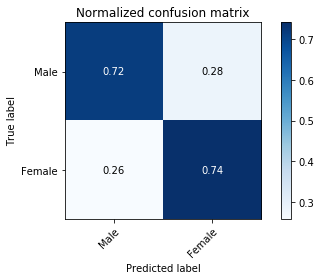

In [49]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

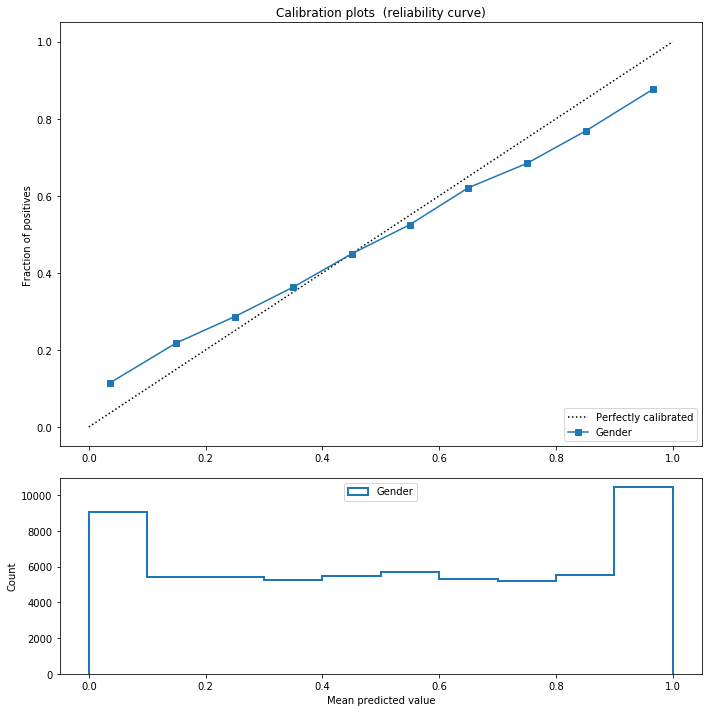

In [50]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Gender')

In [51]:
descr_df = pd.read_csv(main_dir+'data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.shape

/home/yulia/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(62716, 16)

In [52]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs, 
                                   val_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base       0.5        0.17549  58.248453  0.621101   0.659624    392.229001


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.45,0.46,0.99,0.84,0.76,1.01
0.6,0.98,0.86,0.99,0.94,1.09,0.64
1.0,1.53,1.57,1.01,1.17,1.19,1.14


In [53]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
toledos 	 1784.9
shawnee 	 1727.8
overland 	 1699.6
ks 	 1678.0
cathedral 	 1628.5
toledo 	 1615.3
messrs 	 1565.7
eleanor 	 1510.3
west high 	 1487.9
payne of 	 1430.9


bin,1,2,3,4
cathedral,34.0,11.0,59.0,27.0
eleanor,15.0,15.0,89.0,21.0
ks,37.0,11.0,56.0,71.0
messrs,14.0,3.0,168.0,63.0
overland,5.0,2.0,3.0,23.0
payne of,2.0,1.0,2.0,5.0
shawnee,4.0,1.0,5.0,37.0
toledo,21.0,5.0,331.0,44.0
toledos,0.0,0.0,23.0,7.0
west high,3.0,3.0,5.0,11.0


In [54]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr_df)


True positive (Predicted prob: 0.98):

date                 20160711
char_count               3809
word_count                646
speakerid          1.1412e+08
Party                       D
Congress                  114
Chamber                     H
State                      CA
Ethnicity                   B
Age                        70
Age_lt_med                  0
NonWhite                    1
Female                      1
speaker       Ms. JACKSON LEE
Full Name        LEE, BARBARA
match                   exact
Name: 1140107178, dtype: object

 Mr. Chairman. let me thank the gentleman from Georgia for his leadership of the subcommittee from which this legislation. I believe. has found its journey. Let me also acknowledge my colleague from Texas. On the Judiciary Committee. we have the benefit of the counsel of nonlawyers. It is a new phenomenon. When I first came on. we had only lawyers on the committee. But as a lawyer who remembers sitting in an administrative procedure law class 